<a href="https://colab.research.google.com/github/spinafex/crispy-happiness/blob/main/Quant_Methods_of_Statistical_Arbitrage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Strategy Based on the paper Quantitative Methods of Statistical Arbitrage by Boming Ning**

https://hammer.purdue.edu/articles/thesis/Quantitative_Methods_of_Statistical_Arbitrage/25654227/1

The git for this code can be found here: https://github.com/spinafex/cointegrated

In [1]:
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.stattools import coint
from scipy.stats import zscore
import statsmodels.api as sm
from scipy.optimize import minimize
import warnings

The paper uses a reinforced learning (RL) approach to statistical arbitrage. We want to test out the viabilit of this approach. If it works, we can pursue optimization and operationalization.

For now, we are testing the approach on a set of commodities. First, we load the data and process it to remove blanks to avoid NaN errors later.

We split the data into two. One half will be used to train the AI and the other half will be used to test it.

An RL algo is trained on data that usually takes the form: STATE, ACTION and REWARD. Heuristically, we can take STATE to mean the conditions preceding the ACTION. ACTION to mean the decision to buy, sell or hold, and REWARD as the consequence of the decision. This data is generated during the training phase and stored in an object called a q_table.

In [2]:
# Constants for actions
ACTIONS = {'hold': 0, 'buy': 1, 'sell': -1}

# Load data from a CSV file
def load_data(file_path):
    data = pd.read_csv(file_path, index_col=0, parse_dates=True, dayfirst=True)
    data = data.interpolate(method='linear', axis=0, limit_direction='both', limit=5)

    return data

# Split data into training and testing sets
def split_data(data, split_ratio=0.5):
    split_point = int(len(data) * split_ratio)
    train_data = data[:split_point]
    test_data = data[split_point:]
    return train_data, test_data

# Calculate daily returns for the given data
def calculate_daily_returns(data):
    return data.pct_change().dropna()

Since stat arb involves capitalizing on a recurrent relationship, we use the level of cointegration as a measure of the long term nature of a relationship between two assets. If the p-value of the coefficient of cointegration is less than 0.05, we identify the pair as cointegrated.

In [15]:
# Find cointegrated pairs
def find_cointegrated_pairs(train_data):
    returns = calculate_daily_returns(train_data)
    n = returns.shape[1]
    keys = returns.columns
    pairs = []
    pvalues = np.ones((n, n))
    for i, j in itertools.combinations(range(n), 2):
        S1 = returns[keys[i]]
        S2 = returns[keys[j]]
        result = coint(S1, S2)
        pvalue = result[1]
        pvalues[i, j] = pvalue
        if pvalue < 0.05:
            pairs.append((keys[i], keys[j], pvalue))
    return pairs, pvalues

Here we define the basic strategy. We enter a position when the spread is > the mean +  2x the standard deviation or < the mean - 2 x the standard deviation. We exit a position when the spread is < the mean + 0.5x the standard deviation or > the spread - 0.5 x the standard deviation.

In [23]:
# Calculate spreads and z-scores
def calculate_spread_and_zscore(pairs, data):
    spread_results = []
    zscore_results = []
    optimal_entries = []
    optimal_exits = []

    for pair in pairs:
        asset1_name, asset2_name, pvalue = pair
        if asset1_name not in data.columns or asset2_name not in data.columns:
            raise ValueError(f"Asset names {asset1_name} or {asset2_name} not found in data columns.")

        asset1 = data[asset1_name]
        asset2 = data[asset2_name]

        asset1, asset2 = asset1.align(asset2, join='inner')
        combined = pd.DataFrame({'asset1': asset1.ffill(), 'asset2': asset2.ffill()}).dropna()

        if combined.empty:
            continue

        asset1_cleaned = combined['asset1']
        asset2_cleaned = combined['asset2']

        spread = asset1_cleaned - asset2_cleaned
        spread_mean = spread.mean()
        spread_std = spread.std()

        optimal_entry = (spread_std * 2.0)
        optimal_exit = (spread_std * 0.5)

        if spread_std == 0:
            zscore = pd.Series([0] * len(spread), index=spread.index)
        else:
            zscore = (spread - spread_mean) / spread_std

        spread_results.append(spread)
        zscore_results.append(zscore)
        optimal_entries.append(optimal_entry)
        optimal_exits.append(optimal_exit)

    return spread_results, zscore_results, optimal_entries, optimal_exits

The state information tells us whether we are long asset 1 and short asset 2 (when the spread > mean + 2x SD), short asset 1 and long asset 2 (when the spread < mean - 2x SD) or uninvested.

In [24]:
# Generate state information
def generate_state(spreads, optimal_entries, optimal_exits):
    states = []

    for spread_series, optimal_entry, optimal_exit in zip(spreads, optimal_entries, optimal_exits):
        spread_mean = spread_series.mean()
        investable_zone_upper = spread_mean + optimal_entry
        investable_zone_lower = spread_mean - optimal_entry
        exit_zone_upper = spread_mean + optimal_exit
        exit_zone_lower = spread_mean - optimal_exit

        state = []
        current_state = 0  # Start with uninvested
        for t in range(len(spread_series)):
            spread_last2 = spread_series[t-2] if t >= 2 else None
            spread_last = spread_series[t-1] if t >= 1 else None
            spread_now = spread_series[t]

            if current_state == 0:
                if spread_last2 is not None and spread_last is not None:
                    if spread_last2 <= investable_zone_upper and spread_last > investable_zone_upper:
                        current_state = 1  # Invested, short asset1 and long asset2
                    elif spread_last2 >= investable_zone_lower and spread_last < investable_zone_lower:
                        current_state = 2  # Invested, long asset1 and short asset2

            elif current_state == 1:  # Invested, short asset1 and long asset2
                if spread_last2 is not None and spread_last is not None:
                    if spread_last2 >= exit_zone_upper and spread_last < exit_zone_upper:
                        current_state = 0  # Uninvested

            elif current_state == 2:  # Invested, long asset1 and short asset2
                if spread_last2 is not None and spread_last is not None:
                    if spread_last2 <= exit_zone_lower and spread_last > exit_zone_lower:
                        current_state = 0  # Uninvested

            state.append((current_state, spread_last2, spread_last, investable_zone_lower, investable_zone_upper, exit_zone_lower, exit_zone_upper))

        states.append(state)

    return states

In [25]:
# Determine position based on states
def determine_position(states):
    positions = []

    for pair_states in states:
        pair_positions = []
        for state_info in pair_states:
            current_state = state_info[0]
            if current_state == 0:
                pair_positions.append((0, 0))  # Not invested
            elif current_state == 1:
                pair_positions.append((-1, 1))  # Short asset1, long asset2
            elif current_state == 2:
                pair_positions.append((1, -1))  # Long asset1, short asset2
        positions.append(pair_positions)

    return positions

We plot the information to make sure the logic is firing correctly.

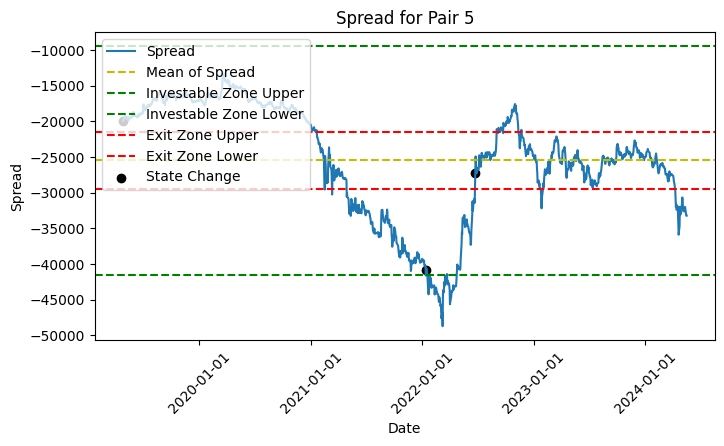

In [38]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

file_path = 'commodities.csv'
data = load_data(file_path)
train_data, test_data = split_data(data)
pairs, _ = find_cointegrated_pairs(train_data)
spread_results, zscore_results, optimal_entries, optimal_exits = calculate_spread_and_zscore(pairs, data)
states = generate_state(spread_results, optimal_entries, optimal_exits)
positions = determine_position(states)

# Select the pair you want to visualize
pair_index = 5  # Change this to the index of the desired pair

# Get the spread and state for the selected pair
spread = spread_results[pair_index]
pair_states = states[pair_index]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the spread
spread_line, = ax.plot(spread.index, spread.values, label='Spread')

# Calculate and plot the mean of the spread
spread_mean = spread.mean()
ax.axhline(spread_mean, color='y', linestyle='--', label='Mean of Spread')

# Set the x-axis tick format to display dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Add horizontal lines for investable and exit zones
investable_zone_upper = spread_mean + optimal_entries[pair_index]
investable_zone_lower = spread_mean - optimal_entries[pair_index]
exit_zone_upper = spread_mean + optimal_exits[pair_index]
exit_zone_lower = spread_mean - optimal_exits[pair_index]

ax.axhline(investable_zone_upper, color='g', linestyle='--', label='Investable Zone Upper')
ax.axhline(investable_zone_lower, color='g', linestyle='--', label='Investable Zone Lower')
ax.axhline(exit_zone_upper, color='r', linestyle='--', label='Exit Zone Upper')
ax.axhline(exit_zone_lower, color='r', linestyle='--', label='Exit Zone Lower')

# Add markers for state changes
state_changes = []
prev_state = None
for i, state_info in enumerate(pair_states):
    current_state = state_info[0]
    if prev_state is None or current_state != prev_state:
        state_changes.append(i)
        prev_state = current_state

ax.scatter(spread.index[state_changes], spread.values[state_changes], marker='o', color='k', label='State Change')

# Set labels and titles
ax.set_xlabel('Date')
ax.set_ylabel('Spread')
ax.set_title(f'Spread for Pair {pair_index}')

# Add legend
ax.legend(loc='upper left')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Show the plot
plt.show()





Now, we calculate the reward data for the q_table.

In [78]:
# Calculate rewards based on positions

file_path = 'commodities.csv'
data = load_data(file_path)
train_data, test_data = split_data(data)
#print(f"Train data shape: {train_data.shape}")
pairs, _ = find_cointegrated_pairs(train_data)
#print(f"Number of Pairs: {len(pairs)}")
spread_results, zscore_results, optimal_entries, optimal_exits = calculate_spread_and_zscore(pairs, train_data)
#print(f"Spread results: {spread_results}")
states = generate_state(spread_results, optimal_entries, optimal_exits)
#print(f"States: {states}")
positions = determine_position(states)
#print(f"Positions length: {len(positions)}")
#print(positions)


def calculate_reward(train_data, pairs, spread_results, positions):
    rewards = []

    for pair_id, (asset1_name, asset2_name, _) in enumerate(pairs):
        try:
            pair_spread = spread_results[pair_id]
            asset1_price = train_data[asset1_name]
            asset2_price = train_data[asset2_name]
            pair_positions = positions[pair_id]  # Get positions for the current pair

            #Debugging code
            #print(f"Processing pair {pair_id}: {asset1_name}, {asset2_name}")
            #print(f"Length of pair_spread: {len(pair_spread)}")
            #print(f"Length of pair_positions: {len(pair_positions)}")
            #print(f"Length of asset1_price: {len(asset1_price)}")
            #print(f"Length of asset2_price: {len(asset2_price)}")

            pair_reward = []
            for t in range(2, len(pair_spread)):
                if t < len(pair_positions):
                    try:
                        position = pair_positions[t]
                        #print(f"Processing t={t}, position={position}")
                        # Uncomment these lines if needed after debugging
                        asset1_reward = float(asset1_price.iloc[t] - asset1_price.iloc[t-2]) * position[0]
                        asset2_reward = float(asset2_price.iloc[t] - asset2_price.iloc[t-2]) * position[1]
                        pair_reward.append(asset1_reward + asset2_reward)
                    except IndexError as e:
                        print(f"IndexError at t={t}: {e}")
                        pair_reward.append(0)
                else:
                    pair_reward.append(0)

            rewards.append(pair_reward)
        except IndexError as e:
            print(f"IndexError for pair {pair_id}: {e}")
            rewards.append([])  # Append an empty list or handle accordingly
        except Exception as e:
            print(f"Unexpected error for pair {pair_id}: {e}")
            rewards.append([])  # Append an empty list or handle accordingly

    return rewards

rewards = calculate_reward(train_data, pairs, spread_results, positions)

#def main():
#    filepath = 'commodities.csv'  # Replace with your actual CSV file path
#    data = load_data(file_path)
#    train_data, test_data = split_data(data)
    #data = load_data(filepath)

#    pairs, _ = find_cointegrated_pairs(train_data)
    #pairs = [
    #    ('CO1', 'CL1', 2.5148137872230502e-05),
    #    ('CO1', 'HG1', 0.0),
        # Add more pairs as needed
    #]

    # Example spread_results and positions generation for testing
#    spread_results = pd.DataFrame(np.random.randn(len(train_data), len(pairs)))
#    positions = [np.random.randint(-1, 2, size=(len(train_data), 2)).tolist() for _ in range(len(pairs))]

#    rewards = calculate_reward(train_data, pairs, spread_results, positions)

#    print(f"Rewards: {rewards}")

#if __name__ == "__main__":
#    main()



Let's plot the cumulative reward for a given pair to make sure that rewards are being calculated correctly

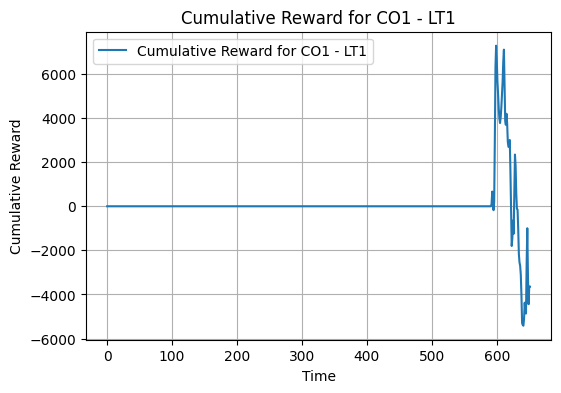

In [84]:

pair_index = 5  # Index of the pair you want to plot
cumulative_reward = np.cumsum(rewards[pair_index])
pair_name = f"{pairs[pair_index][0]} - {pairs[pair_index][1]}"

def plot_cumulative_reward(cumulative_reward, pair):
    plt.figure(figsize=(6, 4))
    plt.plot(cumulative_reward, label=f'Cumulative Reward for {pair}')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Reward')
    plt.title(f'Cumulative Reward for {pair}')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_cumulative_reward(cumulative_reward, pair_name)

Next, we feed STATE, ACTION and REWARD data into the q_learning function.

In [102]:
# Q-learning algorithm (simplified)
ACTIONS = {'hold': 0, 'buy': 1, 'sell': -1}
#actions = ['hold', 'buy', 'sell']
file_path = 'commodities.csv'
data = load_data(file_path)
train_data, test_data = split_data(data)
pairs, _ = find_cointegrated_pairs(train_data)
spread_results, zscore_results, optimal_entries, optimal_exits = calculate_spread_and_zscore(pairs, train_data)
states = generate_state(spread_results, optimal_entries, optimal_exits)
positions = determine_position(states)
rewards = calculate_reward(train_data, pairs, spread_results, positions)

def q_learning(states, rewards, alpha=0.1, gamma=0.9, epsilon=0.1, episodes=1000):
    actions = [0, 1, -1]  # Defining actions: hold, buy, sell
    q_table = {}

    # Ensure all input lists are of the same length
    min_length = min(len(states), len(rewards))

    for episode in range(episodes):
        for t in range(min_length):
            state = states[t]
            reward = rewards[t]

            state_key = tuple(state)  # Convert state to a hashable tuple

            if state_key not in q_table:
                q_table[state_key] = {a: 0 for a in actions}

            if np.random.rand() < epsilon:
                action = np.random.choice(actions)
            else:
                action = max(q_table[state_key], key=q_table[state_key].get)

            next_state = states[t + 1] if t + 1 < min_length else None
            next_state_key = tuple(next_state) if next_state else None

            if next_state_key and next_state_key in q_table:
                best_next_action = max(q_table[next_state_key], key=q_table[next_state_key].get)
                td_target = reward + gamma * q_table[next_state_key][best_next_action]
            else:
                td_target = reward

            if state_key in q_table:
                td_error = td_target - q_table[state_key][action]
                q_table[state_key][action] += alpha * td_error

    return q_table


q_table = q_learning(states, rewards, alpha=0.1, gamma=0.9, epsilon=0.1, episodes=1000)

TypeError: unsupported operand type(s) for -: 'list' and 'int'

using the space to debug q_learning

In [99]:
# Q-learning algorithm (simplified)
ACTIONS = {'hold': 0, 'buy': 1, 'sell': -1}
#actions = ['hold', 'buy', 'sell']
file_path = 'commodities.csv'
data = load_data(file_path)
train_data, test_data = split_data(data)
pairs, _ = find_cointegrated_pairs(train_data)
spread_results, zscore_results, optimal_entries, optimal_exits = calculate_spread_and_zscore(pairs, train_data)
states = generate_state(spread_results, optimal_entries, optimal_exits)
positions = determine_position(states)
rewards = calculate_reward(train_data, pairs, spread_results, positions)

def q_learning(states, actions, rewards, alpha=0.1, gamma=0.9, epsilon=0.1, episodes=1000):
    q_table = {}

    for episode in range(episodes):
        for t, state in enumerate(states):
            action = actions[t]
            reward = rewards[t]  # Get reward for the current time step

            state_key = tuple(state)

            if state_key not in q_table:
                q_table[state_key] = {a: 0 for a in actions}

            if np.random.rand() < epsilon:
                action = np.random.choice(actions)

            next_state = states[t + 1] if t + 1 < len(states) else None
            next_state_key = tuple(next_state) if next_state else None

            if next_state_key and next_state_key in q_table:
                best_next_action = max(q_table[next_state_key], key=q_table[next_state_key].get)
                td_target = reward + gamma * q_table[next_state_key][best_next_action]
            else:
                td_target = reward

            if state_key in q_table:
                td_error = td_target - q_table[state_key][action]
                q_table[state_key][action] += alpha * td_error

    return q_table


q_table = q_learning(states, actions, rewards, alpha=0.1, gamma=0.9, epsilon=0.1, episodes=1000)
print(q_table)

TypeError: unsupported operand type(s) for -: 'list' and 'int'

In [36]:
# Apply reinforcement learning model on test data
def apply_rl_on_test_data(test_data, pairs, q_table):
    spreads, _, optimal_entries, optimal_exits = calculate_spread_and_zscore(pairs, test_data)
    states = generate_state(spreads, optimal_entries, optimal_exits)
    rl_positions = []

    for pair_states in states:
        pair_positions = []
        for state_info in pair_states:
            state_key = tuple(state_info)
            if state_key in q_table:
                action = max(q_table[state_key], key=q_table[state_key].get)
            else:
                action = ACTIONS['hold']

            if action == ACTIONS['hold']:
                pair_positions.append((0, 0))  # Not invested
            elif action == ACTIONS['buy']:
                pair_positions.append((1, -1))  # Long asset1, short asset2
            elif action == ACTIONS['sell']:
                pair_positions.append((-1, 1))  # Short asset1, long asset2

        rl_positions.append(pair_positions)

    return rl_positions